# prep

In [1]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

plt.rcParams['pdf.fonttype'] = 42 # export pdf with editable text compatible with coreldraw
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none' # export svg compatible with coreldraw

import scipy.io as sio
import scipy.stats as stats
import scikit_posthocs as sp

from tqdm import tqdm
from IPython.display import clear_output
import os
import pickle

%load_ext autoreload
%autoreload 2

In [2]:
local_flag = False
if local_flag:
    repo_dir = r'D:\repo\inter_data\inter'.replace("\\", "/") # under env dimred
else:
    repo_dir = r'C:\Users\ll357\Documents\inter/'.replace("\\", "/")
os.chdir(repo_dir)
from src import adp

In [9]:
dir_inter = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
dir_fig = repo_dir + r'\results\tuning bias'.replace('\\', '/')
dir_file = os.path.join(dir_inter, 'adp_dataset_master.xlsx')
data_info = pd.read_excel(dir_file)


meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'LM')
                 & ((data_info.cellpose_seg == True) | (data_info.manual_seg == True))] # ensure segmentation
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)
meta_LM = meta.copy()

meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'V1') 
                 & (data_info.gcamp == '6s') # avoid mixing in gcamp8f
                 & ((data_info.cellpose_seg == True) | (data_info.manual_seg == True))] # there are 2 data in V1 that haven't been segmented due to cellpose failing with low quality tiff
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)
meta_V1 = meta.copy()

meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'LI') 
                 & (data_info.gcamp == '6s') # avoid mixing in gcamp8f
                 & (data_info.manual_seg != 'TODO') # 2 LI data still need manual segm
                 & (data_info.note.str.contains('bad') != True) # exclude bad data
                 ]
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)
meta_LI = meta.copy()

area
LM    22
Name: count, dtype: int64 22
area
V1    6
Name: count, dtype: int64 6
area
LI    18
Name: count, dtype: int64 18


# batch write df_tidy (don't rerun unless needed)

In [1059]:
# meta = pd.concat([meta_V1, meta_LM, meta_LI], axis=0).reset_index(drop=True)
# nset = len(meta)

# for iset in tqdm(range(nset)):
#     print(f'iset={iset}, nset={nset}')


#     ## load data
#     mouse = meta.loc[iset, 'mouse'].astype(str)
#     imouse = 'i' + mouse
#     date = meta.loc[iset, 'date'].astype(str)
#     area = meta.loc[iset, 'area']
#     sess = meta.loc[iset, 'num']
#     print(mouse, date, area, sess)
#     dir_identifier = f'{area}_{imouse}_{date}_{sess}'

#     mat_inter = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
#     for dirname in os.listdir(mat_inter):
#         if dir_identifier in dirname:
#             dir_data = mat_inter + dirname
#             break

#     stim_id, resp_ad, resp_tg = adp.load_resp_trial(os.path.join(dir_data), vis_filter=False) # already sliced by resp time window from matlab. only differentiating isi in resp_tg by indexing into trial. match isi_nframe
#     ## NOTE: stim_id contains the final trial, which should be cut off due to incomplete trial, to match trace_by_trial


#     ## construct dfof
#     R1_dfof = resp_ad.flatten() # cell x trial, row major flatten
#     R2_dfof = resp_tg.flatten()
#     dfof = np.hstack((R1_dfof, R2_dfof)) # sort by cell_id, then trial_id, finally resp_id


#     ## construct cell, trial, resp id
#     ncell = resp_ad.shape[0]
#     ntrial = resp_ad.shape[1]
#     cell_id = np.repeat(np.arange(ncell), ntrial) # repeat cell id arr for ntrial times == sort by cell_id, then trial_id
#     cell_id = np.hstack((cell_id, cell_id)) # stack two copies for R1 and R2. finally sort by resp_id

#     trial_id = np.tile(np.arange(ntrial), ncell) # for each cell, go over all trials
#     trial_id = np.hstack((trial_id, trial_id))

#     len_df = ncell * ntrial * 2 # 2 for (R1, R2)
#     resp_id = ['R1'] * int(len_df/2) + ['R2'] * int(len_df/2) # first half is flattened resp_ad, second half is flattened resp_tg


#     ## construct stim info col: stim 2 orientation, stim 1 orien, isi, adapter contrast
#     trial_stim_orien = [item[0] for item in stim_id['stim_ori']] # print(np.sort(np.unique(trial_stim_orien)))
#     trial_stim_orien_dict = {} ## map stim2 orientation to int. convert from grat ori in deg to 0-based indexing (ensured)
#     for i, item in enumerate(np.sort(np.unique(trial_stim_orien))):
#         trial_stim_orien_dict[item] = i
#     trial_stim_orien_int = [trial_stim_orien_dict[item] for item in trial_stim_orien]

#     trial_isi_nframe = [item[0] for item in stim_id['isi_nframe']]
#     trial_adapter_contrast = [item[0] for item in stim_id['adapter_contrast']]

#     trial_stim_orien_int = trial_stim_orien_int[:ntrial] # if any stim info longer than ntrial, slice off the last one
#     trial_isi_nframe = trial_isi_nframe[:ntrial]
#     trial_adapter_contrast = trial_adapter_contrast[:ntrial]
    

#     ## make stim info col: same as trial_id - tile then hstack
#     stim_id_col = np.tile(trial_stim_orien_int, ncell)
#     isi_col = np.tile(trial_isi_nframe, ncell)
#     ad_con_col = np.tile(trial_adapter_contrast, ncell)

#     stim_id_col = np.hstack((stim_id_col, stim_id_col)) # stim2 orientation
#     isi_col = np.hstack((isi_col, isi_col))
#     ad_con_col = np.hstack((ad_con_col, ad_con_col))

#     df_tidy = pd.DataFrame({'dfof': dfof, 'cell_id': cell_id, 'trial_id': trial_id, 'resp_id': resp_id, 
#                             'isi': isi_col, 'stim1_contrast': ad_con_col, 
#                             'stim2_id': stim_id_col,})
#     df_tidy['area'] = area
#     df_tidy['stim1_id'] = 0 # adapter (stim1) is always 0 deg / vertical gratings
#     df_tidy.loc[(df_tidy.stim1_contrast == 0) & (df_tidy.resp_id == 'R1'), 'dfof'] = np.nan # set R1 to nan if no adapter (stim1_contrast == 0)
#     df_tidy = df_tidy.dropna().reset_index(drop=True) # drop nan rows

#     df_tidy['isi'] = df_tidy['isi'].apply(lambda x: 250 if x <= 10 else 750) # convert isi_nframe to ms. 250 ms is about 8 frames, 750 ms is about 22-23 frames
#     df_tidy.loc[df_tidy.stim1_contrast == 0, 'isi'] = 6000 # set ISI to 6000 ms (equal to ITI) if no adapter (stim1_contrast == 0)


#     ## vis cell filter, well_fit filter, & img driven cell-stim filter
#     df_tidy['filter_cell_vis'] = np.nan
#     df_tidy['filter_cell_vis_pval'] = np.nan # allow continuous filtering on how significant the cell gets visually driven
#     df_tidy['filter_cell_well_fit'] = np.nan
#     df_tidy['filter_cell_stim'] = np.nan

#     with open(os.path.join(dir_data, 'vis_driven_ttest_bonferroni.pickle'), 'rb') as f: # changed to strict bonferroni
#     # with open(os.path.join(dir_data, 'vis_driven_ttest_bonferroni_strict.pickle'), 'rb') as f: # changed to strict bonferroni
#         filter_file = pickle.load(f)
#     filter_cell_stim = filter_file['img_driven']
#     filter_cell_vis = filter_file['vis_driven']
#     filter_cell_vis_pval = np.min(filter_file['p_ttest'], axis=1) # min pval across all stim
        
#     well_fit = sio.loadmat(os.path.join(dir_data, 'fit_bootstrap_90perc.mat'))
#     well_fit_cell = np.array([x[0] for x in well_fit['well_fit_cell']])

#     for icell in np.arange(filter_cell_stim.shape[0]): # filter_cell_stim is ncell x nstim
#         df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_vis'] = filter_cell_vis[icell]
#         df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_vis_pval'] = filter_cell_vis_pval[icell]
#         df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_well_fit'] = well_fit_cell[icell]
#         for istim in np.arange(filter_cell_stim.shape[1]):
#             df_tidy.loc[(df_tidy['stim2_id']==istim) & (df_tidy['cell_id']==icell), 'filter_cell_stim'] = filter_cell_stim[icell, istim]
#     # df_tidy.filter_cell_vis.value_counts(), df_tidy.filter_cell_stim.value_counts()


#     # ## cell tuning in 3 possible ISI, 2 runs (each run uses half of the trials)
#     # fit_tuning_half = sio.loadmat(os.path.join(dir_data, 'fit_tuning_half_trials.mat'))
#     # ori_pref_run1 = fit_tuning_half['ori_pref_runs'][:, :, 0] # ncell x 3isi x 2run, [noad vs ad750 vs ad250]
#     # ori_pref_run2 = fit_tuning_half['ori_pref_runs'][:, :, 1]

#     # ori_pref_runs_sorted = well_fit['ori_pref_runs']
#     # # ori_pref_runs_sorted = np.array([np.sort(x) for x in well_fit['ori_pref_runs']]) # ncell x nrun. sort each row of ori_pref_runs
#     # # for icell in np.arange(10):
#     # #     plt.plot(ori_pref_runs_sorted[icell, :])

#     # percentile_threshold = 0.9
#     # # if area == 'LI':
#     # #     percentile_threshold = 0.7 # taken from well_fit_cell_criteria(_relax).m, only relax for LI
#     # nrun = ori_pref_runs_sorted.shape[1]
#     # rand_idx = np.random.randint(nrun*(1-percentile_threshold), nrun*percentile_threshold, size=2) # # bc well_fit cells are defined as: 90% of bootstrapped ori_pref within 22.5 deg, randomly select 2 indices between 100-900 in ori_pref_runs_sorted
#     # ori_pref_noad1 = ori_pref_runs_sorted[:, rand_idx[0]] # ncell x 1
#     # ori_pref_noad2 = ori_pref_runs_sorted[:, rand_idx[1]]


#     # ## goodness of fit (R square) in isi 250 or 750
#     # fit_tuning = sio.loadmat(os.path.join(dir_data, 'fit_tuning_isi3.mat')) # fit_tuning['fit_param'].shape # ncell x nparam x nstim
#     # R_square = fit_tuning['fit_param'][:, -1, :] # ncell x nstim, final param is R_square of fit
#     # R_square_750 = R_square[:, 1] # use R_sq to determine well_fit_ad
#     # R_square_250 = R_square[:, 2]
#     # well_fit_ad_250 = R_square_250 >= np.percentile(R_square_250, 50) # ncell x 1. only take top 50% of R_sq
#     # well_fit_ad_750 = R_square_750 >= np.percentile(R_square_750, 50)


#     # ## write cell property to df_tidy
#     # ncell = df_tidy.cell_id.unique().shape[0]
#     # for icell in np.arange(ncell):
#     #     df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_noad'] = ori_pref_run1[icell, 0] # ori_pref_run1 is ncell x 3isi, [noad vs ad750 vs ad250]
#     #     df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_ad_750'] = ori_pref_run1[icell, 1]
#     #     df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_ad_250'] = ori_pref_run1[icell, 2]

#     #     df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_noad1'] = ori_pref_run1[icell, 0] # for control plot. ori_pref_noad1 is same as ori_pref_noad
#     #     df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_noad2'] = ori_pref_run2[icell, 0] # take from another run

#     #     df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_well_fit_ad_250'] = well_fit_ad_250[icell]
#     #     df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_well_fit_ad_750'] = well_fit_ad_750[icell]
    
#     # break

#     ## save df_tidy as csv
#     df_tidy.to_csv(os.path.join(dir_data, 'df_tidy_continuous_vis_pval.csv'), index=False)

# # clear_output()

  0%|          | 0/46 [00:00<?, ?it/s]

iset=0, nset=46
1323 200720 V1 003
ncell: 103, nstim: 8, ntrial: 463


  2%|▏         | 1/46 [00:04<03:36,  4.82s/it]

iset=1, nset=46
1324 200728 V1 003
ncell: 93, nstim: 8, ntrial: 463


  4%|▍         | 2/46 [00:16<06:26,  8.79s/it]

iset=2, nset=46
1322 200803 V1 002
ncell: 97, nstim: 8, ntrial: 463


  7%|▋         | 3/46 [00:31<08:20, 11.64s/it]

iset=3, nset=46
1328 201015 V1 004
ncell: 82, nstim: 8, ntrial: 464


  9%|▊         | 4/46 [00:45<08:44, 12.48s/it]

iset=4, nset=46
1329 201209 V1 002
ncell: 146, nstim: 8, ntrial: 463


 11%|█         | 5/46 [01:01<09:28, 13.86s/it]

iset=5, nset=46
1337 210120 V1 003
ncell: 62, nstim: 8, ntrial: 464


 13%|█▎        | 6/46 [01:13<08:42, 13.06s/it]

iset=6, nset=46
1323 200721 LM 002
ncell: 39, nstim: 8, ntrial: 465


 15%|█▌        | 7/46 [01:17<06:44, 10.36s/it]

iset=7, nset=46
1324 200729 LM 003
ncell: 52, nstim: 8, ntrial: 464


 17%|█▋        | 8/46 [01:25<05:56,  9.39s/it]

iset=8, nset=46
1322 200804 LM 003
ncell: 69, nstim: 8, ntrial: 464


 20%|█▉        | 9/46 [01:38<06:38, 10.77s/it]

iset=9, nset=46
1328 201119 LM 003
ncell: 71, nstim: 8, ntrial: 464


 22%|██▏       | 10/46 [01:49<06:24, 10.67s/it]

iset=10, nset=46
1328 201127 LM 002
ncell: 40, nstim: 8, ntrial: 463


 24%|██▍       | 11/46 [01:55<05:24,  9.26s/it]

iset=11, nset=46
1329 201217 LM 002
ncell: 107, nstim: 8, ntrial: 464


 26%|██▌       | 12/46 [02:07<05:48, 10.26s/it]

iset=12, nset=46
1329 201217 LM 004
ncell: 90, nstim: 8, ntrial: 463


 28%|██▊       | 13/46 [02:22<06:17, 11.43s/it]

iset=13, nset=46
1337 210127 LM 002
ncell: 86, nstim: 8, ntrial: 464


 30%|███       | 14/46 [02:35<06:20, 11.88s/it]

iset=14, nset=46
1337 210127 LM 003
ncell: 62, nstim: 8, ntrial: 463


 33%|███▎      | 15/46 [02:45<05:57, 11.54s/it]

iset=15, nset=46
1338 210325 LM 002
ncell: 85, nstim: 8, ntrial: 465


 35%|███▍      | 16/46 [02:58<05:55, 11.84s/it]

iset=16, nset=46
1338 210805 LM 002
ncell: 80, nstim: 8, ntrial: 463


 37%|███▋      | 17/46 [03:10<05:44, 11.87s/it]

iset=17, nset=46
1350 211020 LM 002
ncell: 62, nstim: 8, ntrial: 463


 39%|███▉      | 18/46 [03:21<05:28, 11.73s/it]

iset=18, nset=46
1350 211020 LM 003
ncell: 68, nstim: 8, ntrial: 463


 41%|████▏     | 19/46 [03:29<04:44, 10.54s/it]

iset=19, nset=46
1351 220228 LM 002
ncell: 63, nstim: 8, ntrial: 464


 43%|████▎     | 20/46 [03:36<04:07,  9.52s/it]

iset=20, nset=46
1351 220228 LM 003
ncell: 72, nstim: 8, ntrial: 464


 46%|████▌     | 21/46 [03:47<04:05,  9.82s/it]

iset=21, nset=46
1380 230221 LM 002
ncell: 67, nstim: 8, ntrial: 500


 48%|████▊     | 22/46 [03:59<04:16, 10.67s/it]

iset=22, nset=46
1380 230221 LM 003
ncell: 36, nstim: 8, ntrial: 501


 50%|█████     | 23/46 [04:05<03:28,  9.08s/it]

iset=23, nset=46
1373 230302 LM 003
ncell: 139, nstim: 8, ntrial: 502


 52%|█████▏    | 24/46 [04:23<04:19, 11.80s/it]

iset=24, nset=46
1373 230302 LM 004
ncell: 142, nstim: 8, ntrial: 500


 54%|█████▍    | 25/46 [04:44<05:05, 14.56s/it]

iset=25, nset=46
1381 230307 LM 002
ncell: 87, nstim: 8, ntrial: 500


 57%|█████▋    | 26/46 [05:02<05:13, 15.67s/it]

iset=26, nset=46
1381 230307 LM 003
ncell: 98, nstim: 8, ntrial: 500


 59%|█████▊    | 27/46 [05:16<04:47, 15.14s/it]

iset=27, nset=46
1381 230307 LM 004
ncell: 100, nstim: 8, ntrial: 500


 61%|██████    | 28/46 [05:31<04:33, 15.20s/it]

iset=28, nset=46
1323 200723 LI 003
ncell: 33, nstim: 8, ntrial: 464


 63%|██████▎   | 29/46 [05:36<03:23, 11.96s/it]

iset=29, nset=46
1322 200806 LI 003
ncell: 53, nstim: 8, ntrial: 464


 65%|██████▌   | 30/46 [05:42<02:45, 10.35s/it]

iset=30, nset=46
1328 201202 LI 003
ncell: 9, nstim: 8, ntrial: 463


 67%|██████▋   | 31/46 [05:43<01:53,  7.59s/it]

iset=31, nset=46
1328 201202 LI 004
ncell: 29, nstim: 8, ntrial: 463


 70%|██████▉   | 32/46 [05:49<01:38,  7.04s/it]

iset=32, nset=46
1329 210113 LI 004
ncell: 22, nstim: 8, ntrial: 464


 72%|███████▏  | 33/46 [05:56<01:28,  6.83s/it]

iset=33, nset=46
1329 210113 LI 006
ncell: 23, nstim: 8, ntrial: 463


 74%|███████▍  | 34/46 [05:59<01:09,  5.77s/it]

iset=34, nset=46
1337 210203 LI 003
ncell: 43, nstim: 8, ntrial: 463


 76%|███████▌  | 35/46 [06:06<01:06,  6.09s/it]

iset=35, nset=46
1337 210203 LI 004
ncell: 25, nstim: 8, ntrial: 463


 78%|███████▊  | 36/46 [06:10<00:56,  5.61s/it]

iset=36, nset=46
1339 210930 LI 002
ncell: 24, nstim: 8, ntrial: 462


 80%|████████  | 37/46 [06:13<00:42,  4.68s/it]

iset=37, nset=46
1339 210930 LI 003
ncell: 25, nstim: 8, ntrial: 463


 83%|████████▎ | 38/46 [06:18<00:38,  4.81s/it]

iset=38, nset=46
1350 211028 LI 002
ncell: 35, nstim: 8, ntrial: 464


 85%|████████▍ | 39/46 [06:23<00:35,  5.05s/it]

iset=39, nset=46
1350 211028 LI 003
ncell: 34, nstim: 8, ntrial: 462


 87%|████████▋ | 40/46 [06:29<00:31,  5.19s/it]

iset=40, nset=46
1380 230110 LI 002
ncell: 35, nstim: 8, ntrial: 463


 89%|████████▉ | 41/46 [06:33<00:24,  4.89s/it]

iset=41, nset=46
1380 230110 LI 003
ncell: 15, nstim: 8, ntrial: 462


 91%|█████████▏| 42/46 [06:36<00:16,  4.18s/it]

iset=42, nset=46
1373 230228 LI 002
ncell: 73, nstim: 8, ntrial: 501


 93%|█████████▎| 43/46 [06:50<00:21,  7.16s/it]

iset=43, nset=46
1373 230228 LI 003
ncell: 86, nstim: 8, ntrial: 502


 96%|█████████▌| 44/46 [07:04<00:18,  9.43s/it]

iset=44, nset=46
1381 230309 LI 002
ncell: 94, nstim: 8, ntrial: 501


 98%|█████████▊| 45/46 [07:17<00:10, 10.44s/it]

iset=45, nset=46
1381 230309 LI 003
ncell: 33, nstim: 8, ntrial: 478


100%|██████████| 46/46 [07:22<00:00,  9.62s/it]


# batch load df_tidy

In [7]:
meta = pd.concat([meta_V1, meta_LM, meta_LI], axis=0).reset_index(drop=True)
nset = len(meta)
df_tidy = pd.DataFrame()

for iset in tqdm(range(nset)):
    # print(f'iset={iset}, nset={nset}')

    mouse = meta.loc[iset, 'mouse'].astype(str)
    imouse = 'i' + mouse
    date = meta.loc[iset, 'date'].astype(str)
    area = meta.loc[iset, 'area']
    sess = meta.loc[iset, 'num']
    # print(imouse, date, area, sess)
    dir_identifier = f'{area}_{imouse}_{date}_{sess}'

    dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    csv_filename = 'df_tidy_continuous_vis_pval.csv'
    try:
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))
    except:
        dir_identifier = dir_identifier + '_cellpose'
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))

    df_tidy_now['mouse'] = mouse
    df_tidy_now['date'] = date
    df_tidy_now['sess'] = sess
    df_tidy_now['cell_id'] = (df_tidy_now.date.astype(str) + '_' 
                               + df_tidy_now.sess.astype(str) + '_' 
                               + df_tidy_now.cell_id.astype(str)) # cell_id adjusted to be unique across mice, dates, sessions
    df_tidy = pd.concat([df_tidy, df_tidy_now], axis=0).reset_index(drop=True)
    # break
    
df_tidy['date_sess'] = df_tidy.date.astype(str) + '_' + df_tidy.sess.astype(str)
clear_output()

# adaptation by area

## R1 & adp across area

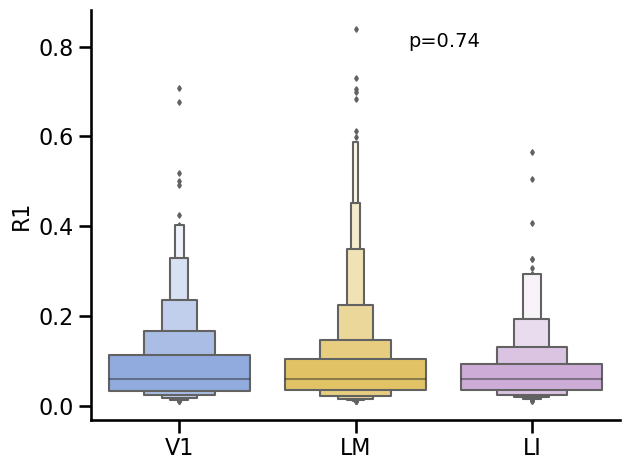

In [434]:
def R1_in_area(df_filter):

    gb_R1 = df_filter[(df_filter.stim2_id == 0) & (df_filter.resp_id == 'R1') & (df_filter.isi == 250)].groupby(['area', 'cell_id']).dfof.mean().values # avg over rep trials
    gb_R2 = df_filter[(df_filter.stim2_id == 0) & (df_filter.resp_id == 'R2') & (df_filter.isi == 250)].groupby(['area', 'cell_id']).dfof.mean().values
    # gb_adp = (gb_R2 - gb_R1) / (gb_R1 + 1e-7)

    gb_R1 = gb_R1[(np.abs(gb_R1 >= 0.01)) 
                # & (np.abs(gb_adp) < 3) # NOTE: no need to thresh adp when we thresh R1
                ] # NOTE: use the same cell filter as func adp_in_area
    return gb_R1


df_filter = df_tidy[(df_tidy.filter_cell_vis == True)
                    ]
gb_R1_V1 = R1_in_area(df_filter[df_filter.area == 'V1'])
gb_R1_LM = R1_in_area(df_filter[df_filter.area == 'LM'])
gb_R1_LI = R1_in_area(df_filter[df_filter.area == 'LI'])


ax = sns.boxenplot(data=[gb_R1_V1, gb_R1_LM, gb_R1_LI], 
                palette=['#85A7EB', '#F6CD51', '#D1A6DE'], 
                linewidth=1.5, flier_kws=dict(s=5),
                )

_, p_kruskal = stats.kruskal(gb_R1_V1, gb_R1_LM, gb_R1_LI)
plt.text(1.3, 0.8, 'p={:.2f}'.format(p_kruskal), fontsize=14)

plt.xticks([0, 1, 2], ['V1', 'LM', 'LI'], fontsize=16);
plt.ylabel('R1', fontsize=16);
sns.despine();
plt.tight_layout();

# plt.savefig(os.path.join(dir_fig, 'fig2_R1_by_area_grat8_vis_bonf_corel_R1mean_boxen.svg'))

In [435]:
## kruskal wallis test
print(stats.kruskal(gb_R1_V1, gb_R1_LM, gb_R1_LI))

## mann whitney u test (Wilcoxon rank-sum test)
stats.mannwhitneyu(gb_R1_V1, gb_R1_LM), stats.mannwhitneyu(gb_R1_V1, gb_R1_LI), stats.mannwhitneyu(gb_R1_LM, gb_R1_LI)

KruskalResult(statistic=0.6043757164097769, pvalue=0.73919918721292)


(MannwhitneyuResult(statistic=167338.0, pvalue=0.79069954051261),
 MannwhitneyuResult(statistic=39403.0, pvalue=0.4432952607028007),
 MannwhitneyuResult(statistic=84697.0, pvalue=0.5186684572321033))

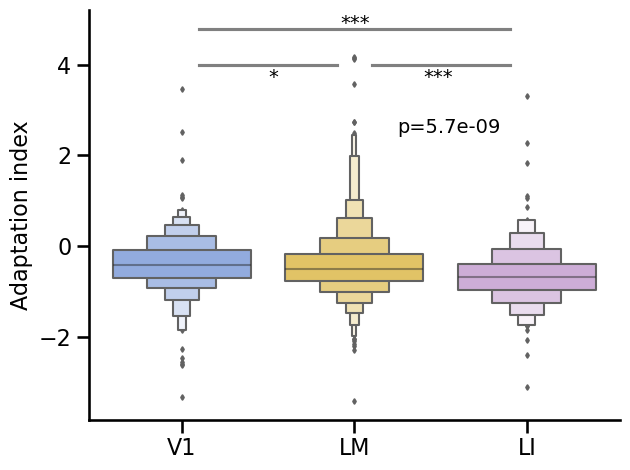

In [439]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) ## suppress FutureWarning

def adp_in_area(df_filter):

    gb_R1 = df_filter[(df_filter.stim2_id == 0) & (df_filter.resp_id == 'R1') & (df_filter.isi == 250)].groupby(['area', 'cell_id']).dfof.mean().values
    gb_R2 = df_filter[(df_filter.stim2_id == 0) & (df_filter.resp_id == 'R2') & (df_filter.isi == 250)].groupby(['area', 'cell_id']).dfof.mean().values
    gb_adp = (gb_R2 - gb_R1) / (gb_R1 + 1e-7)
    
    gb_adp = gb_adp[(np.abs(gb_R1 >= 0.01)) 
                    # & (np.abs(gb_adp) < 3) 
                    ]

    return gb_adp


df_filter = df_tidy[(df_tidy.filter_cell_vis == True)
                    ]
gb_adp_V1 = adp_in_area(df_filter[df_filter.area == 'V1'])
gb_adp_LM = adp_in_area(df_filter[df_filter.area == 'LM'])
gb_adp_LI = adp_in_area(df_filter[df_filter.area == 'LI'])


# ax = sns.violinplot(data=[gb_adp_V1, gb_adp_LM, gb_adp_LI], 
#                     palette=['#85A7EB', '#F6CD51', '#D1A6DE'], 
#                     )

ax = sns.boxenplot(data=[gb_adp_V1, gb_adp_LM, gb_adp_LI], 
                palette=['#85A7EB', '#F6CD51', '#D1A6DE'], 
                linewidth=1.5, flier_kws=dict(s=5),
                )

## add pvlaue for kruskal wallis test (non-parametric ANOVA)
_, p_kruskal = stats.kruskal(gb_adp_V1, gb_adp_LM, gb_adp_LI)
plt.text(1.25, 2.5, 'p={:.1e}'.format(p_kruskal), fontsize=14)

## add significance stars for posthoc mann whitney u test (Wilcoxon rank-sum test)
_, p_mannwhit_V1LM = stats.mannwhitneyu(gb_adp_V1, gb_adp_LM)
_, p_mannwhit_LMLI = stats.mannwhitneyu(gb_adp_LM, gb_adp_LI)
_, p_mannwhit_V1LI = stats.mannwhitneyu(gb_adp_V1, gb_adp_LI)
p_mannwhit = [p_mannwhit_V1LM, p_mannwhit_LMLI, p_mannwhit_V1LI]
sig_star_str = []
for i, pval in enumerate(p_mannwhit):
    if pval < 0.001:
        sig_star_str.append('***')
    elif pval < 0.01:
        sig_star_str.append('**')
    elif pval < 0.05:
        sig_star_str.append('*')
    else:
        sig_star_str.append('n.s.')

## first, draw horizontal lines to connect pairs of groups
sig_bar_y = 4
sig_bar_shorten = 0.1
plt.plot([0+sig_bar_shorten, 1-sig_bar_shorten], [sig_bar_y, sig_bar_y], 'gray')
# sig_bar_y += 0.2
plt.plot([1+sig_bar_shorten, 2-sig_bar_shorten], [sig_bar_y, sig_bar_y], 'gray')
sig_bar_y += 0.8
plt.plot([0+sig_bar_shorten, 2-sig_bar_shorten], [sig_bar_y, sig_bar_y], 'gray')

## then, draw significance stars
sig_star_y_base = 3.6
sig_star_y = [sig_star_y_base, sig_star_y_base, sig_star_y_base+1.2]
sig_star_x = [0.5, 1.4, 0.92] # V1-LM, LM-LI, V1-LI
for i, sig_star in enumerate(sig_star_str):
    plt.text(sig_star_x[i], sig_star_y[i], sig_star, fontsize=14)


plt.xticks([0, 1, 2], ['V1', 'LM', 'LI'], fontsize=16);
plt.ylabel('Adaptation index', fontsize=16);
sns.despine();
plt.tight_layout();

# plt.savefig(os.path.join(dir_fig, 'fig2_adp_by_area_grat8_vis_bonf_corel_filterR1_posthoc_R1mean_boxen.svg'))

In [235]:
## kruskal wallis test
print(stats.kruskal(gb_adp_V1, gb_adp_LM, gb_adp_LI))

## mann whitney u test (Wilcoxon rank-sum test)
stats.mannwhitneyu(gb_adp_V1, gb_adp_LM), stats.mannwhitneyu(gb_adp_V1, gb_adp_LI), stats.mannwhitneyu(gb_adp_LM, gb_adp_LI)

KruskalResult(statistic=37.96777452365859, pvalue=5.693804051543348e-09)


(MannwhitneyuResult(statistic=179880.0, pvalue=0.016035923421124657),
 MannwhitneyuResult(statistic=49558.0, pvalue=1.5129602428432972e-09),
 MannwhitneyuResult(statistic=101085.0, pvalue=6.382559491951187e-07))

In [460]:
## dunn test (posthoc test for kruskal wallis): https://scikit-posthocs.readthedocs.io/en/latest/generated/scikit_posthocs.posthoc_dunn.html
sp.posthoc_dunn([gb_adp_V1, gb_adp_LM], p_adjust='bonferroni'), sp.posthoc_dunn([gb_adp_V1, gb_adp_LI], p_adjust='bonferroni'), sp.posthoc_dunn([gb_adp_LM, gb_adp_LI], p_adjust='bonferroni')

(          1         2
 1  1.000000  0.016032
 2  0.016032  1.000000,
               1             2
 1  1.000000e+00  1.510525e-09
 2  1.510525e-09  1.000000e+00,
               1             2
 1  1.000000e+00  6.378201e-07
 2  6.378201e-07  1.000000e+00)

## vis cell % stacked histogram 

In [205]:
df_cell_property = df_tidy.groupby('cell_id').first()
df_cell_property['vis_str'] = 'p>=0.05'

nstim = df_tidy.stim2_id.nunique()
df_cell_property.loc[df_cell_property.filter_cell_vis_pval < 0.05 / nstim, 'vis_str'] = '0.01<=p<0.05' # bonferroni correction
df_cell_property.loc[df_cell_property.filter_cell_vis_pval < 0.01 / nstim, 'vis_str'] = 'p<0.01'

df_vis_hist = df_cell_property.groupby('area').vis_str.value_counts().unstack()
df_vis_hist = df_vis_hist.iloc[::-1] # row order: V1, LM, LI
df_vis_hist = df_vis_hist.iloc[:, [2, 0, 1]] # column order: not visually driven -> moderately -> strongly visually driven

df_vis_hist['ncell_total'] = df_vis_hist.sum(axis=1)
for col in df_vis_hist.columns[:-1]: # normalize by total cell number in each area
    df_vis_hist[col] = df_vis_hist[col] / df_vis_hist.ncell_total * 100 # convert to percentage
df_vis_hist = df_vis_hist.drop(columns='ncell_total', axis=1) # drop column ncell_total

df_vis_hist

vis_str,p>=0.05,0.01<=p<0.05,p<0.01
area,,,
V1,50.943396,16.981132,32.075472
LM,63.848397,12.653061,23.498542
LI,82.199711,7.235890,10.564399


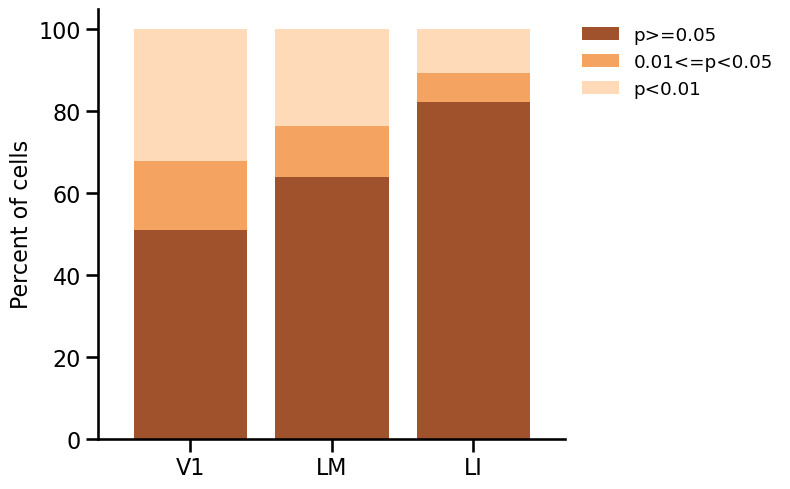

In [206]:
(df_vis_hist
    .plot(kind='bar', stacked=True,
    figsize=(8, 5), 
    # colormap=ListedColormap(["darkred", "indianred", "lightcoral"]), 
    colormap=ListedColormap(["sienna", "sandybrown", "peachpuff"]), 
    width=0.8) # make bar thinner
    );

# ## set alpha
# alpha = 0.7
# plt.gca().patches[0].set_alpha(alpha)

plt.legend(frameon=False, bbox_to_anchor=(1, 1));
plt.xticks(rotation=0, fontsize=16); # rotate x tick labels back to horizontal
plt.xlabel('')
plt.ylabel('Percent of cells', fontsize=16);
sns.despine();
plt.tight_layout();

# plt.savefig(os.path.join(dir_fig, 'vis_cell_by_area_recolor_percent.svg'))

# tuning bias with well-max
take max resp as ori_pref

## filter cell well-max (no rerun)

In [26]:
## construct tuning_vec column

max_ori_bootstrap = np.array([])
nboot = 50

for iboot in tqdm(range(nboot)):
    max_ori = (df_tidy[df_tidy.resp_id == 'R2'] # only R2 has diff ori
                [['dfof', 'cell_id', 'resp_id', 'isi', 'stim2_id']]
                .groupby(['cell_id', 'isi', 'stim2_id'])
                .sample(frac=.7, random_state=iboot) # sample x trials per group. min rep = 48
                .groupby(['cell_id', 'isi', 'stim2_id'])
                .agg({'dfof': 'mean'}) # aggregate resp by cell, isi, ori
                .groupby(['cell_id', 'isi']).apply(lambda x: np.argmax(x)) # get ori with max resp
                .reset_index() # NOTE: due to prev groupby, cell_id and isi are in order
                .rename(columns={0: 'max_ori'}).max_ori.values
                )
    max_ori_bootstrap = np.append(max_ori_bootstrap, max_ori)

100%|██████████| 50/50 [03:50<00:00,  4.61s/it]


In [27]:
max_ori_bootstrap = max_ori_bootstrap.reshape(nboot, -1) # reshape max_ori_bootstrap to: nboot x (ncell x nisi)

## sort max_ori_bootstrap in each col (across boots)
max_ori_bootstrap = np.sort(max_ori_bootstrap, axis=0)
# sns.heatmap(max_ori_bootstrap[:, 10:30], cmap='viridis', cbar=True, annot=True);

## count the most freq value in each col (across boots)
max_ori_mode_freq = stats.mode(max_ori_bootstrap, axis=0)[1] # count of mode (freq of most freq max_ori)
filter_cell_well_max = (max_ori_mode_freq >= nboot * 0.7) # NOTE: strictness of well-max can be adjusted here

## merge filter_cell_well_max with df
df_well_max = (df_tidy[df_tidy.resp_id == 'R2'][['cell_id', 'isi']]
                .groupby(['cell_id', 'isi'])
                .first() # get first trial per cell, isi
                .reset_index() # due to prev groupby, cell_id and isi are in the same order as max_ori
                )
df_well_max['filter_cell_well_max'] = filter_cell_well_max
df_well_max

,cell_id,isi,filter_cell_well_max
0,200720_003_0,250,False
1,200720_003_0,750,True
2,200720_003_0,6000,False
3,200720_003_1,250,True
4,200720_003_1,750,False
...,...,...,...
8962,230309_003_8,750,False
8963,230309_003_8,6000,True
8964,230309_003_9,250,True
8965,230309_003_9,750,False


In [28]:
## inherit df_well_max['filter_cell_well_max']
df_tidy = df_tidy.merge(
      df_well_max, 
      on=['cell_id', 'isi'], how='left') # take filter_cell_well_max from df_well_max, for each cell and isi
df_tidy

,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,filter_cell_vis_pval,filter_cell_well_fit,filter_cell_stim,mouse,date,sess,date_sess,filter_cell_well_max
0,-0.003253,200720_003_0,0,R1,750,1,5,V1,0,True,0.006817,1.0,False,1323,200720,003,200720_003,True
1,0.088726,200720_003_0,1,R1,250,1,2,V1,0,True,0.006817,1.0,False,1323,200720,003,200720_003,False
2,-0.010485,200720_003_0,2,R1,250,1,2,V1,0,True,0.006817,1.0,False,1323,200720,003,200720_003,False
3,-0.050493,200720_003_0,3,R1,750,1,3,V1,0,True,0.006817,1.0,False,1323,200720,003,200720_003,True
4,0.052611,200720_003_0,5,R1,750,1,0,V1,0,True,0.006817,1.0,False,1323,200720,003,200720_003,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2413843,0.074167,230309_003_32,473,R2,750,1,6,LI,0,False,0.181598,0.0,False,1381,230309,003,230309_003,False
2413844,-0.023736,230309_003_32,474,R2,750,1,0,LI,0,False,0.181598,0.0,False,1381,230309,003,230309_003,False
2413845,0.060245,230309_003_32,475,R2,250,1,1,LI,0,False,0.181598,0.0,False,1381,230309,003,230309_003,True
2413846,0.009333,230309_003_32,476,R2,6000,0,2,LI,0,False,0.181598,0.0,False,1381,230309,003,230309_003,False


## pref-ori as max-ori (no rerun)
crude preference: take max-resp orientation as the preferred orien

In [29]:
pref_ori_noad = (df_tidy[(df_tidy.resp_id == 'R2') & (df_tidy.isi == 6000)]
                .groupby(['cell_id', 'stim2_id'])
                [['dfof']].sum().reset_index()
                .groupby('cell_id') # NOTE: stim2_id is sorted due to prev groupby
                ['dfof'].apply(list).to_frame()
                .dfof.apply(lambda x: np.argmax(x)).to_frame()
                .rename(columns={'dfof': 'pref_ori_noad'})
                )

pref_ori_ad_250 = (df_tidy[(df_tidy.resp_id == 'R2') & (df_tidy.isi == 250)]
                .groupby(['cell_id', 'stim2_id'])
                [['dfof']].sum().reset_index()
                .groupby('cell_id') # NOTE: stim2_id is sorted due to prev groupby
                ['dfof'].apply(list).to_frame()
                .dfof.apply(lambda x: np.argmax(x)).to_frame()
                .rename(columns={'dfof': 'pref_ori_ad_250'})
                )

pref_ori_ad_750 = (df_tidy[(df_tidy.resp_id == 'R2') & (df_tidy.isi == 750)]
                .groupby(['cell_id', 'stim2_id'])
                [['dfof']].sum().reset_index()
                .groupby('cell_id') # NOTE: stim2_id is sorted due to prev groupby
                ['dfof'].apply(list).to_frame()
                .dfof.apply(lambda x: np.argmax(x)).to_frame()
                .rename(columns={'dfof': 'pref_ori_ad_750'})
                )

df_tidy = (df_tidy.merge(pref_ori_noad, on='cell_id')
            .merge(pref_ori_ad_250, on='cell_id')
            .merge(pref_ori_ad_750, on='cell_id'))
df_tidy

,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,...,filter_cell_well_fit,filter_cell_stim,mouse,date,sess,date_sess,filter_cell_well_max,pref_ori_noad,pref_ori_ad_250,pref_ori_ad_750
0,-0.003253,200720_003_0,0,R1,750,1,5,V1,0,True,...,1.0,False,1323,200720,003,200720_003,True,4,3,3
1,0.088726,200720_003_0,1,R1,250,1,2,V1,0,True,...,1.0,False,1323,200720,003,200720_003,False,4,3,3
2,-0.010485,200720_003_0,2,R1,250,1,2,V1,0,True,...,1.0,False,1323,200720,003,200720_003,False,4,3,3
3,-0.050493,200720_003_0,3,R1,750,1,3,V1,0,True,...,1.0,False,1323,200720,003,200720_003,True,4,3,3
4,0.052611,200720_003_0,5,R1,750,1,0,V1,0,True,...,1.0,False,1323,200720,003,200720_003,True,4,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2413843,0.074167,230309_003_32,473,R2,750,1,6,LI,0,False,...,0.0,False,1381,230309,003,230309_003,False,5,0,7
2413844,-0.023736,230309_003_32,474,R2,750,1,0,LI,0,False,...,0.0,False,1381,230309,003,230309_003,False,5,0,7
2413845,0.060245,230309_003_32,475,R2,250,1,1,LI,0,False,...,0.0,False,1381,230309,003,230309_003,True,5,0,7
2413846,0.009333,230309_003_32,476,R2,6000,0,2,LI,0,False,...,0.0,False,1381,230309,003,230309_003,False,5,0,7


In [30]:
def bin_ori(x):
    # bin pref ori to 0, 45, 90
    if x < 30:
        return 0
    elif x <= 60:
        return 45
    else:
        return 90

def distace_from_adapter(x):
    # adapter is always 0 deg
    x = 22.5*x # convert from stim id int to degree
    if x > 90:
        x = 180 - x
    return x


df_tidy['pref_unadapted_distance'] = df_tidy['pref_ori_noad'].apply(lambda x: distace_from_adapter(x)) # unadapted pref ori, distance from adapter
df_tidy['pref_unadapted_distance_bin'] = df_tidy['pref_unadapted_distance'].apply(lambda x: bin_ori(x)) # bin the distance to 0, 45, 90

df_tidy.loc[(df_tidy.isi == 250), 'pref_adapted_distance'] = df_tidy['pref_ori_ad_250'].apply(lambda x: distace_from_adapter(x)) # isi 250 adapted pref ori, distance from adapter # TODO: refactor pref_ori_ad_250 similarly, so it's only one column of pref_ori_ad, but can filter by isi
df_tidy.loc[(df_tidy.isi == 750), 'pref_adapted_distance'] = df_tidy['pref_ori_ad_750'].apply(lambda x: distace_from_adapter(x)) # isi 750 adapted pref ori, distance from adapter

df_tidy['tuning_bias'] = df_tidy['pref_adapted_distance'] - df_tidy['pref_unadapted_distance'] # distance from adapter, adapted - unadapted. if tuning repelled from adapter, this is positive; attracted, negative

df_tidy.sample(5, random_state=0)

,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,...,sess,date_sess,filter_cell_well_max,pref_ori_noad,pref_ori_ad_250,pref_ori_ad_750,pref_unadapted_distance,pref_unadapted_distance_bin,pref_adapted_distance,tuning_bias
1535086,0.070788,230302_004_53,353,R2,750,1,3,LM,0,True,...,004,230302_004,True,5,3,3,67.5,90,67.5,0.0
1498362,-0.001468,230302_004_10,50,R2,250,1,7,LM,0,True,...,004,230302_004,False,0,0,7,0.0,0,0.0,0.0
10251,-0.030888,200720_003_13,84,R1,250,1,6,V1,0,True,...,003,200720_003,True,0,0,0,0.0,0,0.0,0.0
26153,-0.020128,200720_003_33,401,R1,250,1,0,V1,0,False,...,003,200720_003,True,7,7,3,22.5,0,22.5,0.0
1794444,0.021428,230307_004_31,149,R2,250,1,3,LM,0,False,...,004,230307_004,True,6,6,7,45.0,45,45.0,0.0


## read csv for well-max

In [384]:
dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\df tidy for plots/'.replace('\\', '/')
# df_tidy.to_csv(os.path.join(dir_data, 'df_tidy_tuning_bias_wellmax.csv'), index=False) # takes 80 sec
df_tidy = pd.read_csv(os.path.join(dir_data, 'df_tidy_tuning_bias_wellmax.csv'))
df_tidy.sample(5, random_state=0)

,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,...,date,sess,filter_cell_well_max,pref_ori_noad,pref_ori_ad_250,pref_ori_ad_750,pref_unadapted_distance,pref_unadapted_distance_bin,pref_adapted_distance,tuning_bias
1535086,0.070788,230302_004_53,353,R2,750,1,3,LM,0,True,...,230302,4,True,5,3,3,67.5,90,67.5,0.0
1498362,-0.001468,230302_004_10,50,R2,250,1,7,LM,0,True,...,230302,4,False,0,0,7,0.0,0,0.0,0.0
10251,-0.030888,200720_003_13,84,R1,250,1,6,V1,0,True,...,200720,3,True,0,0,0,0.0,0,0.0,0.0
26153,-0.020128,200720_003_33,401,R1,250,1,0,V1,0,False,...,200720,3,True,7,7,3,22.5,0,22.5,0.0
1794444,0.021428,230307_004_31,149,R2,250,1,3,LM,0,False,...,230307,4,True,6,6,7,45.0,45,45.0,0.0


### write well-max.mat for pop vec decoder

In [417]:
pd.options.mode.chained_assignment = None  # default='warn', suppress SettingWithCopyWarning

df_well_max = df_tidy[df_tidy.isi == 6000] # determine well max cell in ISI=6k
df_well_max['date_sess'] = df_well_max.date.astype(str) + '_00' + df_well_max.sess.astype(str)

for date_sess in tqdm(df_well_max.date_sess.unique()):

    df_well_max_sess = df_well_max[df_well_max.date_sess == date_sess]
    df_well_max_sess = df_well_max_sess[['date_sess', 'cell_id', 'filter_cell_well_max']]
    df_well_max_sess['cell_id_int'] = df_well_max_sess.cell_id.str.split('_').apply(lambda x: int(x[-1])) # cast cell_id from str to int
    df_well_max_sess = df_well_max_sess.groupby('cell_id_int').first().reset_index() # groupby sorts cell_id
    well_max_sess = df_well_max_sess.filter_cell_well_max.values.astype(float) # well max cell filter in this session. must cast to float for matlab to index with bool

    ## find session subdir in mat_inter
    mat_inter = r'Z:\All_Staff\home\lan\Data\2P_images\mat_inter'.replace('\\', '/')
    for dirname in os.listdir(mat_inter):
        if date_sess in dirname: # this accounts for cellpose vs manual segm
            dir_sess = mat_inter + '/' + dirname
            break
    
    ## save well max .mat
    sio.savemat(os.path.join(dir_sess, 'well_max.mat'), {'well_max': well_max_sess})

100%|██████████| 46/46 [00:02<00:00, 20.00it/s]


## well-max cell % stacked histogram

In [385]:
tmp = df_tidy.groupby('cell_id').first().reset_index()
tmp[(tmp.filter_cell_vis == True) & (tmp.isi == 250)].groupby(['area']).filter_cell_well_fit.mean()

area
LI    0.136364
LM    0.364238
V1    0.426667
Name: filter_cell_well_fit, dtype: float64

In [386]:
tmp[(tmp.filter_cell_vis == True) & (tmp.isi == 250)].groupby(['area']).filter_cell_well_max.mean()

area
LI    0.528409
LM    0.543046
V1    0.560000
Name: filter_cell_well_max, dtype: float64

In [387]:
df_cell_property = df_tidy[(df_tidy.filter_cell_vis == True) & (df_tidy.isi == 6000)].groupby('cell_id').first()
# df_cell_property['filter_cell_well_fit'] = df_cell_property['filter_cell_well_fit'].astype(bool)

df_cell_property['well_str'] = 'none'
df_cell_property.loc[(df_cell_property.filter_cell_well_max == True), 'well_str'] = 'well-tuned' # aka well-max, aka consistent-max

# df_cell_property['well_str'] = 'neither'
# df_cell_property.loc[(df_cell_property.filter_cell_well_max == False) 
#                      & (df_cell_property.filter_cell_well_fit == True), 'well_str'] = 'only consistent-fit' # bonferroni correction
# df_cell_property.loc[(df_cell_property.filter_cell_well_max == True) 
#                      & (df_cell_property.filter_cell_well_fit == False), 'well_str'] = 'only consistent-max'
# df_cell_property.loc[(df_cell_property.filter_cell_well_max == True) 
#                      & (df_cell_property.filter_cell_well_fit == True), 'well_str'] = 'both'


df_well_hist = df_cell_property.groupby('area')[['well_str']].value_counts().unstack()
df_well_hist = df_well_hist.iloc[::-1] # row order: V1, LM, LI
# df_well_hist = df_well_hist.iloc[:, [1, 2, 0, 3]] # column order
df_well_hist['ncell_total'] = df_well_hist.sum(axis=1)
for col in df_well_hist.columns[:-1]: # normalize by total cell number in each area
    df_well_hist[col] = df_well_hist[col] / df_well_hist.ncell_total * 100 # convert to percentage
df_well_hist = df_well_hist.drop(columns='ncell_total', axis=1) # drop column ncell_total
df_well_hist

well_str,none,well-tuned
area,,
V1,34.075724,65.924276
LM,41.200407,58.799593
LI,56.756757,43.243243


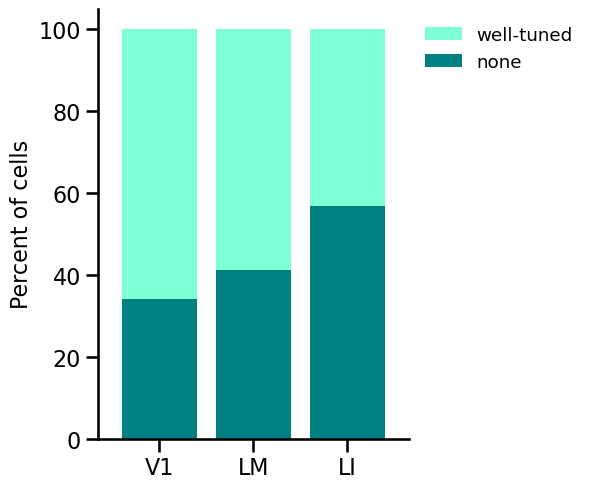

In [389]:
(df_well_hist
    .plot(kind='bar', stacked=True, 
    figsize=(6, 5), 
    colormap=ListedColormap(["teal", "darkturquoise", "turquoise", 'aquamarine']), 
    width=0.8) # make bar thinner
    );

plt.legend();
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], frameon=False, bbox_to_anchor=(1, 1))

plt.xticks(rotation=0, fontsize=16); # rotate x tick labels back to horizontal
plt.xlabel('')
plt.ylabel('Percent of cells', fontsize=16);
sns.despine();
plt.tight_layout();

# plt.savefig(os.path.join(dir_fig, 'well_max_cell_by_area_percent_in_vis_isi6k.svg'))

## tuning bias plot

In [32]:
df_filter = df_tidy[(df_tidy.filter_cell_vis == True) 
                    & (df_tidy.filter_cell_well_max == True)
                    & (df_tidy.isi == 250)
                    ]
df_filter = df_filter.groupby('cell_id').first().reset_index() # drop duplicate cell_id
df_filter.groupby('area').cell_id.nunique()

area
LI    112
LM    532
V1    281
Name: cell_id, dtype: int64

In [ ]:
bias_0_V1 = df_filter[(df_filter.pref_unadapted_distance_bin == 0) & (df_filter.area == 'V1')].tuning_bias.values
bias_0_LM = df_filter[(df_filter.pref_unadapted_distance_bin == 0) & (df_filter.area == 'LM')].tuning_bias.values
bias_0_LI = df_filter[(df_filter.pref_unadapted_distance_bin == 0) & (df_filter.area == 'LI')].tuning_bias.values
print(stats.kruskal(bias_0_V1, bias_0_LM, bias_0_LI))

bias_45_V1 = df_filter[(df_filter.pref_unadapted_distance_bin == 45) & (df_filter.area == 'V1')].tuning_bias.values
bias_45_LM = df_filter[(df_filter.pref_unadapted_distance_bin == 45) & (df_filter.area == 'LM')].tuning_bias.values
bias_45_LI = df_filter[(df_filter.pref_unadapted_distance_bin == 45) & (df_filter.area == 'LI')].tuning_bias.values
print(stats.kruskal(bias_45_V1, bias_45_LM, bias_45_LI))

bias_90_V1 = df_filter[(df_filter.pref_unadapted_distance_bin == 90) & (df_filter.area == 'V1')].tuning_bias.values
bias_90_LM = df_filter[(df_filter.pref_unadapted_distance_bin == 90) & (df_filter.area == 'LM')].tuning_bias.values
bias_90_LI = df_filter[(df_filter.pref_unadapted_distance_bin == 90) & (df_filter.area == 'LI')].tuning_bias.values
print(stats.kruskal(bias_90_V1, bias_90_LM, bias_90_LI))

KruskalResult(statistic=21.597479716168692, pvalue=2.0425225884058178e-05)
KruskalResult(statistic=5.2026785459656955, pvalue=0.07417417219844605)
KruskalResult(statistic=3.2773047556309245, pvalue=0.19424163032056777)


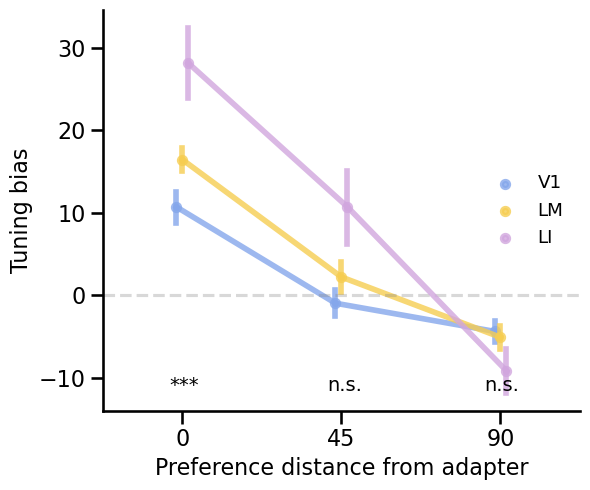

In [140]:
fig, axes = plt.subplots(1, 1, figsize=(6, 5), sharey=True)
ax = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias', data=df_filter, hue='area',
                   dodge=True, markers='.', palette=['#85A7EB', '#F6CD51', '#D1A6DE'],
                   errorbar=('ci', 68), #errwidthfloat=1, capsize=.1,
                   )


y_sig = 0.05
ax.text(0.14, y_sig, '***', transform=ax.transAxes, fontsize=14)
ax.text(0.47, y_sig, 'n.s.', transform=ax.transAxes, fontsize=14)
ax.text(0.8, y_sig, 'n.s.', transform=ax.transAxes, fontsize=14)

plt.setp(ax.collections, alpha=.8);
plt.setp(ax.lines, alpha=.8);
plt.axhline(0, color='gray', linestyle='--', alpha=.3);

plt.legend(frameon=False, loc='right');
plt.xlabel('Preference distance from adapter', fontsize=16);
plt.xticks([0, 1, 2], ['0', '45', '90'], fontsize=16);
plt.ylabel('Tuning bias', fontsize=16);
sns.despine();
plt.tight_layout();

# plt.savefig(os.path.join(dir_fig, 'tuning_bias_wellmax_by_area_grat8_vis_bonf_corel.svg'))

In [468]:
# ## paired t test
# (stats.ttest_rel(bias_0_V1, bias_0_LM, alternative='less'), # expect gOSI to be higher when isi=6000
#  stats.ttest_rel(bias_0_LM, bias_0_LI, alternative='less'),
# stats.ttest_rel(bias_0_V1, bias_0_LI, alternative='less'))

## dunn test (posthoc test for kruskal wallis): https://scikit-posthocs.readthedocs.io/en/latest/generated/scikit_posthocs.posthoc_dunn.html
sp.posthoc_dunn([bias_0_V1, bias_0_LM], p_adjust='bonferroni'), sp.posthoc_dunn([bias_0_V1, bias_0_LI], p_adjust='bonferroni'), sp.posthoc_dunn([bias_0_LM, bias_0_LI], p_adjust='bonferroni')

(          1         2
 1  1.000000  0.001335
 2  0.001335  1.000000,
           1         2
 1  1.000000  0.000007
 2  0.000007  1.000000,
           1         2
 1  1.000000  0.008036
 2  0.008036  1.000000)

# tuning curve

## tuning curve with R1 cell filter
match "R1 & adp across area" section

In [290]:
df_R1_ori0 = df_tidy[(df_tidy.stim2_id == 0) & (df_tidy.resp_id == 'R1') & (df_tidy.isi == 250)].groupby(['cell_id']).dfof.mean().abs().reset_index()
df_R1_ori0['filter_cell_R1_ori0'] = df_R1_ori0.dfof >= 0.01 # match filter of section "R1 & adp across area"
# df_R1_ori0.groupby('filter_cell_R1_ori0').cell_id.nunique()
df_R1_ori0 = df_R1_ori0.drop(columns=['dfof'])

df_tuning = df_tidy[['dfof', 'cell_id', 'resp_id', 'isi', 'stim2_id', 
                    'area', 'filter_cell_vis', 'filter_cell_well_fit', 'filter_cell_well_max',
                    'pref_ori_noad', 'pref_ori_ad_250', 
                    'pref_unadapted_distance', 'pref_unadapted_distance_bin', 'pref_adapted_distance', 
                    'tuning_bias',
                    ]]
df_tuning = df_tuning.merge(df_R1_ori0, on='cell_id', how='inner') # inherit filter_cell_R1_ori0 from df_R1_ori0

df_tuning = df_tuning[(df_tuning.isi > -1) # placeholder, always true
                    & (df_tuning.filter_cell_vis == True)
                    & (df_tuning.filter_cell_R1_ori0 == True)
                    & ((df_tuning.isi == 250) | (df_tuning.isi == 6000))
                    ]
df_tuning

,dfof,cell_id,resp_id,isi,stim2_id,area,filter_cell_vis,filter_cell_well_fit,filter_cell_well_max,pref_ori_noad,pref_ori_ad_250,pref_unadapted_distance,pref_unadapted_distance_bin,pref_adapted_distance,tuning_bias,filter_cell_R1_ori0
1,0.088726,200720_003_0,R1,250,2,V1,True,1.0,False,4,3,90.0,90,67.5,-22.5,True
2,-0.010485,200720_003_0,R1,250,2,V1,True,1.0,False,4,3,90.0,90,67.5,-22.5,True
5,0.123572,200720_003_0,R1,250,7,V1,True,1.0,False,4,3,90.0,90,67.5,-22.5,True
7,-0.005172,200720_003_0,R1,250,4,V1,True,1.0,False,4,3,90.0,90,67.5,-22.5,True
8,-0.056392,200720_003_0,R1,250,5,V1,True,1.0,False,4,3,90.0,90,67.5,-22.5,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2375126,-0.025242,230309_002_79,R2,6000,3,LI,True,0.0,False,2,6,45.0,45,NaN,NaN,True
2375127,0.081034,230309_002_79,R2,6000,2,LI,True,0.0,False,2,6,45.0,45,NaN,NaN,True
2375129,0.108352,230309_002_79,R2,6000,0,LI,True,0.0,False,2,6,45.0,45,NaN,NaN,True
2375130,0.269638,230309_002_79,R2,250,4,LI,True,0.0,True,2,6,45.0,45,45.0,0.0,True


## tuning curve with well-max cell filter

In [84]:
dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\df tidy for plots/'.replace('\\', '/')
# df_tidy.to_csv(os.path.join(dir_data, 'df_tidy_tuning_bias_wellmax.csv'), index=False) # takes 80 sec
df_tidy = pd.read_csv(os.path.join(dir_data, 'df_tidy_tuning_bias_wellmax.csv'))
df_tidy.sample(5, random_state=0)

,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,...,date,sess,filter_cell_well_max,pref_ori_noad,pref_ori_ad_250,pref_ori_ad_750,pref_unadapted_distance,pref_unadapted_distance_bin,pref_adapted_distance,tuning_bias
1535086,0.070788,230302_004_53,353,R2,750,1,3,LM,0,True,...,230302,4,True,5,3,3,67.5,90,67.5,0.0
1498362,-0.001468,230302_004_10,50,R2,250,1,7,LM,0,True,...,230302,4,False,0,0,7,0.0,0,0.0,0.0
10251,-0.030888,200720_003_13,84,R1,250,1,6,V1,0,True,...,200720,3,True,0,0,0,0.0,0,0.0,0.0
26153,-0.020128,200720_003_33,401,R1,250,1,0,V1,0,False,...,200720,3,True,7,7,3,22.5,0,22.5,0.0
1794444,0.021428,230307_004_31,149,R2,250,1,3,LM,0,False,...,230307,4,True,6,6,7,45.0,45,45.0,0.0


In [ ]:
df_tuning = df_tidy[['dfof', 'cell_id', 'resp_id', 'isi', 'stim2_id', 
                    'area', 'filter_cell_vis', 'filter_cell_well_fit', 'filter_cell_well_max',
                    'pref_ori_noad', 'pref_ori_ad_250', 
                    'pref_unadapted_distance', 'pref_unadapted_distance_bin', 'pref_adapted_distance', 
                    'tuning_bias', #'tuning_bias_control',
                    ]]
df_tuning = df_tuning[(df_tuning.isi > -1) # placeholder, always true
                    & (df_tuning.filter_cell_vis == True)
                    & ((df_tuning.filter_cell_well_fit == True) | (df_tuning.filter_cell_well_max == True))
                    & ((df_tuning.isi == 250) | (df_tuning.isi == 6000))
                    ]

## calc df_tuning & save

In [261]:
df_tuning['tuning_noad'] = np.pi
df_tuning['tuning_250'] = np.pi

for icell in tqdm(df_tuning.cell_id.unique()):
    ## tuning curve when isi = 6000, no adapter
    tuning_noad = df_tuning.loc[(df_tuning.cell_id == icell) & (df_tuning.isi == 6000) & (df_tuning.resp_id == 'R2'), :].groupby(['stim2_id'], sort=True).dfof.agg(np.nanmean).values # groupby sort: sorted by key, aka stim2_id. take R2 of no adapter trials to get tuning curve when no adapter
    df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_noad'] = df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_noad'].apply(lambda x: tuning_noad)
    
    ## tuning curve when isi = 250
    tuning_250 = df_tuning.loc[(df_tuning.cell_id == icell) & (df_tuning.isi == 250) & (df_tuning.resp_id == 'R2'), :].groupby(['stim2_id'], sort=True).dfof.agg(np.nanmean).values
    df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_250'] = df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_250'].apply(lambda x: tuning_250)

# df_tuning.sort_values(by=['tuning_bias'], inplace=True, ascending=False) # df_tuning sort by tuning_bias_distance
df_tuning.sample(5, random_state=0) # NOTE: where isi=6000, pref_adapted_distance and tuning_bias are NaN

100%|██████████| 1468/1468 [07:56<00:00,  3.08it/s]


,dfof,cell_id,resp_id,isi,stim2_id,area,filter_cell_vis,filter_cell_well_fit,filter_cell_well_max,filter_cell_R1_ori0,tuning_noad,tuning_250
310074,-0.040260,201209_002_19,R1,250,2,V1,True,1.0,True,True,"[0.0652363724001989, 0.01251529236293756, 0.00...","[0.038911534492796974, 0.02897431398994536, 0...."
1446200,0.325443,230302_003_88,R1,250,5,LM,True,1.0,True,True,"[0.09680831203155954, 0.07610871203573787, 0.0...","[0.012244531386720324, 0.026481653858568294, 0..."
1557906,0.102816,230302_004_80,R2,6000,6,LM,True,0.0,False,True,"[0.08768147712508101, 0.029399147125566148, 0....","[0.041498675570561756, 0.06055428521146898, 0...."
488499,0.189454,200721_002_37,R1,250,3,LM,True,0.0,True,True,"[0.11777973910240594, 0.028325999300029193, 0....","[0.022666701606969007, 0.029099350341821647, 0..."
1739643,0.008594,230307_003_65,R1,250,5,LM,True,0.0,False,True,"[0.12156124860672121, 0.08566065440517139, 0.1...","[0.051720435704512444, 0.07538524042767285, 0...."


In [293]:
dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\df tidy for plots/'.replace('\\', '/')
# df_tuning.to_csv(os.path.join(dir_data, 'df_tidy_tuning_curve_match_R1_ori0_filter.csv'), index=False)
df_tuning = pd.read_csv(os.path.join(dir_data, 'df_tidy_tuning_curve_match_R1_ori0_filter.csv'))
df_tuning.sample(5, random_state=0)

,dfof,cell_id,resp_id,isi,stim2_id,area,filter_cell_vis,filter_cell_well_fit,filter_cell_well_max,filter_cell_R1_ori0,tuning_noad,tuning_250
128990,-0.040260,201209_002_19,R1,250,2,V1,True,1.0,True,True,[ 0.06523637 0.01251529 0.00616671 -0.001798...,[ 0.03891153 0.02897431 0.03476853 -0.003945...
480227,0.325443,230302_003_88,R1,250,5,LM,True,1.0,True,True,[0.09680831 0.07610871 0.03586269 0.01743957 0...,[0.01224453 0.02648165 0.00589288 0.0296173 0...
526876,0.102816,230302_004_80,R2,6000,6,LM,True,0.0,False,True,[0.08768148 0.02939915 0.02317821 0.07869847 0...,[0.04149868 0.06055429 0.00210185 0.0508441 0...
196785,0.189454,200721_002_37,R1,250,3,LM,True,0.0,True,True,[0.11777974 0.028326 0.03848072 0.04215961 0...,[ 0.0226667 0.02909935 0.01139628 -0.025142...
595365,0.008594,230307_003_65,R1,250,5,LM,True,0.0,False,True,[0.12156125 0.08566065 0.10211343 0.04788407 0...,[0.05172044 0.07538524 0.03519829 0.05148809 0...


In [264]:
## only run this if using well-max filter

# ## find where tuning_noad or tuning_250 is empty list, get cell id
# ## this is bc well-max is calc per cell x isi, cannot guarantee that all isi are well-max for the same cell
# bad_cell_noad = df_tuning.loc[df_tuning.tuning_noad.apply(lambda x: len(x)) == 0, 'cell_id'].unique()
# bad_cell_250 = df_tuning.loc[df_tuning.tuning_250.apply(lambda x: len(x)) == 0, 'cell_id'].unique()
# bad_cell = np.unique(np.append(bad_cell_noad, bad_cell_250))
# print(len(bad_cell), df_tuning.cell_id.nunique())

# ## drop bad_cell from df_tuning
# df_tuning = df_tuning[~df_tuning.cell_id.isin(bad_cell)]
df_tuning.cell_id.nunique()

1468

## tuning across area & ISI

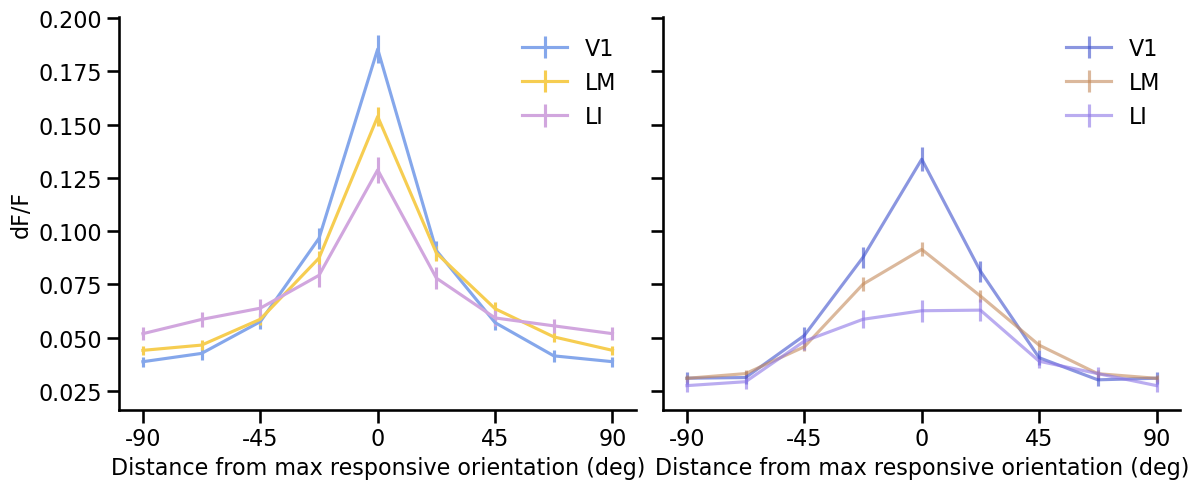

In [280]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
color_list = '85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-8c75e6' # originally https://coolors.co/85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-c715f4, changed last color
color_list = color_list.split('-') # V1 (unadapted, adapted) - LM (unadapted, adapted) - LI (unadapted, adapted)
color_list = ['#' + i for i in color_list]
color_list_noad = color_list[::2]
color_list_250 = color_list[1::2]


for i, iarea in enumerate(['V1', 'LM', 'LI']):
    tuning_pop = df_tuning[df_tuning.area == iarea].groupby(['cell_id']).tuning_noad.first().values
    tuning_pop_250 = df_tuning[df_tuning.area == iarea].groupby(['cell_id']).tuning_250.first().values
    nori = len(tuning_pop[0])
    tuning_pop = np.concatenate(tuning_pop).reshape(-1, nori) # reshape array of arrays to 2d array. ncell x nstim (nori)
    tuning_pop_250 = np.concatenate(tuning_pop_250).reshape(-1, nori)

    ## find pref ori by argmax along ori axis. determined in noad trials
    pref_ori = np.argmax(tuning_pop, axis=1) # ncell

    ## align tuning curve by pref ori
    tuning_pop_aligned = np.zeros_like(tuning_pop)
    tuning_pop_aligned_250 = np.zeros_like(tuning_pop_250)
    for icell in range(tuning_pop.shape[0]):
        tuning_pop_aligned[icell] = np.roll(tuning_pop[icell], nori//2 - pref_ori[icell]) # shift by nori//2 - pref_ori
        tuning_pop_aligned_250[icell] = np.roll(tuning_pop_250[icell], nori//2 - pref_ori[icell]) # align by pref_ori of noad (before adp)

    tuning_pop_avg = np.nanmean(tuning_pop_aligned, axis=0) # average across cells
    tuning_pop_avg = np.append(tuning_pop_avg, tuning_pop_avg[0]) # append first element to the end, so it's a circle
    tuning_pop_avg_250 = np.nanmean(tuning_pop_aligned_250, axis=0)
    tuning_pop_avg_250 = np.append(tuning_pop_avg_250, tuning_pop_avg_250[0])

    tuning_pop_sem = np.nanstd(tuning_pop_aligned, axis=0) / np.sqrt(tuning_pop.shape[0]) # sem across cells
    tuning_pop_sem = np.append(tuning_pop_sem, tuning_pop_sem[0])
    tuning_pop_sem_250 = np.nanstd(tuning_pop_aligned_250, axis=0) / np.sqrt(tuning_pop_250.shape[0])
    tuning_pop_sem_250 = np.append(tuning_pop_sem_250, tuning_pop_sem_250[0])

    ax[0].errorbar(np.arange(len(tuning_pop_avg)), # + i*0.1, 
                tuning_pop_avg, 
                yerr=tuning_pop_sem, 
                label=iarea, alpha=1, 
                color=color_list_noad[i],)
    
    ax[1].errorbar(np.arange(len(tuning_pop_avg_250)), # + i*0.1, 
                tuning_pop_avg_250, 
                yerr=tuning_pop_sem_250, 
                label=iarea, alpha=.6, 
                color=color_list_250[i],)

ax[0].set_ylabel('dF/F', fontsize=16)
ax[0].set_xlabel('Distance from max responsive orientation (deg)', fontsize=16)
ax[1].set_xlabel('Distance from max responsive orientation (deg)', fontsize=16)

xlabels = [str(int(t)) for t in np.arange(-90, 90 + 180/nori*2, 180/nori*2)]
ax[0].set_xticks(np.arange(0, len(tuning_pop_avg), 2), xlabels);

ax[0].legend(frameon=False, loc='upper right', fontsize=16);
ax[1].legend(frameon=False, loc='upper right', fontsize=16);
sns.despine();
plt.tight_layout();

# fig.savefig(os.path.join(dir_fig, 'tuning_curve_by_area, R1-ori0 cell filter.svg'))

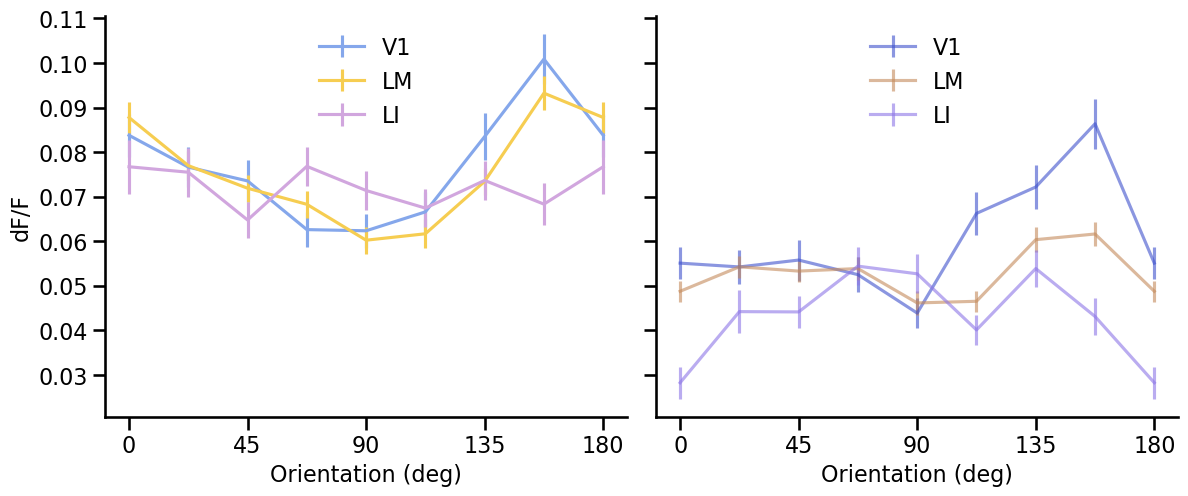

In [283]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
color_list = '85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-8c75e6' # originally https://coolors.co/85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-c715f4, changed last color
color_list = color_list.split('-') # V1 (unadapted, adapted) - LM (unadapted, adapted) - LI (unadapted, adapted)
color_list = ['#' + i for i in color_list]
color_list_noad = color_list[::2]
color_list_250 = color_list[1::2]


for i, iarea in enumerate(['V1', 'LM', 'LI']):
    tuning_pop = df_tuning[df_tuning.area == iarea].groupby(['cell_id']).tuning_noad.first().values
    tuning_pop_250 = df_tuning[df_tuning.area == iarea].groupby(['cell_id']).tuning_250.first().values
    nori = len(tuning_pop[0])
    tuning_pop = np.concatenate(tuning_pop).reshape(-1, nori) # reshape array of arrays to 2d array. ncell x nstim (nori)
    tuning_pop_250 = np.concatenate(tuning_pop_250).reshape(-1, nori)

    ## find pref ori by argmax along ori axis. determined in noad trials
    pref_ori = np.argmax(tuning_pop, axis=1) # ncell

    ## NOTE: no align
    tuning_pop_aligned = tuning_pop
    tuning_pop_aligned_250 = tuning_pop_250

    tuning_pop_avg = np.nanmean(tuning_pop_aligned, axis=0) # average across cells
    tuning_pop_avg = np.append(tuning_pop_avg, tuning_pop_avg[0]) # append first element to the end, so it's a circle
    tuning_pop_avg_250 = np.nanmean(tuning_pop_aligned_250, axis=0)
    tuning_pop_avg_250 = np.append(tuning_pop_avg_250, tuning_pop_avg_250[0])

    tuning_pop_sem = np.nanstd(tuning_pop_aligned, axis=0) / np.sqrt(tuning_pop.shape[0]) # sem across cells
    tuning_pop_sem = np.append(tuning_pop_sem, tuning_pop_sem[0])
    tuning_pop_sem_250 = np.nanstd(tuning_pop_aligned_250, axis=0) / np.sqrt(tuning_pop_250.shape[0])
    tuning_pop_sem_250 = np.append(tuning_pop_sem_250, tuning_pop_sem_250[0])

    ax[0].errorbar(np.arange(len(tuning_pop_avg)), # + i*0.1, 
                tuning_pop_avg, 
                yerr=tuning_pop_sem, 
                label=iarea, alpha=1, 
                color=color_list_noad[i],)
    
    ax[1].errorbar(np.arange(len(tuning_pop_avg_250)), # + i*0.1, 
                tuning_pop_avg_250, 
                yerr=tuning_pop_sem_250, 
                label=iarea, alpha=.6, 
                color=color_list_250[i],)

ax[0].set_ylabel('dF/F', fontsize=16)
ax[0].set_xlabel('Orientation (deg)', fontsize=16)
ax[1].set_xlabel('Orientation (deg)', fontsize=16)

xlabels = [str(int(t)) for t in np.arange(-0, 180 + 180/nori*2, 180/nori*2)]
ax[0].set_xticks(np.arange(0, len(tuning_pop_avg), 2), xlabels);

ax[0].legend(frameon=False, loc='upper center', fontsize=16);
ax[1].legend(frameon=False, loc='upper center', fontsize=16);
sns.despine();
plt.tight_layout();

# fig.savefig(os.path.join(dir_fig, 'ori_resp_by_area, R1-ori0 cell filter.svg'))

## polar plot of tuning
before and after adaptation  
filter cells 

In [291]:
# https://stackoverflow.com/questions/58065055/floor-and-ceil-with-number-of-decimals

def my_ceil(a, decimal=0):
    # my_ceil(0.123, decimal=2) = 0.13
    return np.true_divide(np.ceil(a * 10**decimal), 10**decimal)

def my_floor(a, decimal=0):
    # my_floor(0.123, decimal=2) = 0.12
    return np.true_divide(np.floor(a * 10**decimal), 10**decimal)

[0.26129802,
 0.04687393,
 -0.00581764,
 -0.03536233,
 -0.01525381,
 -0.02285146,
 -0.00976033,
 0.19785956]

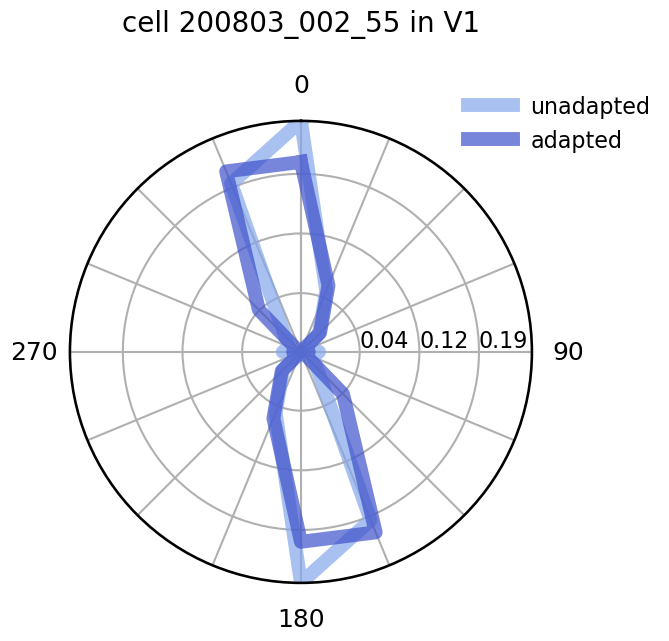

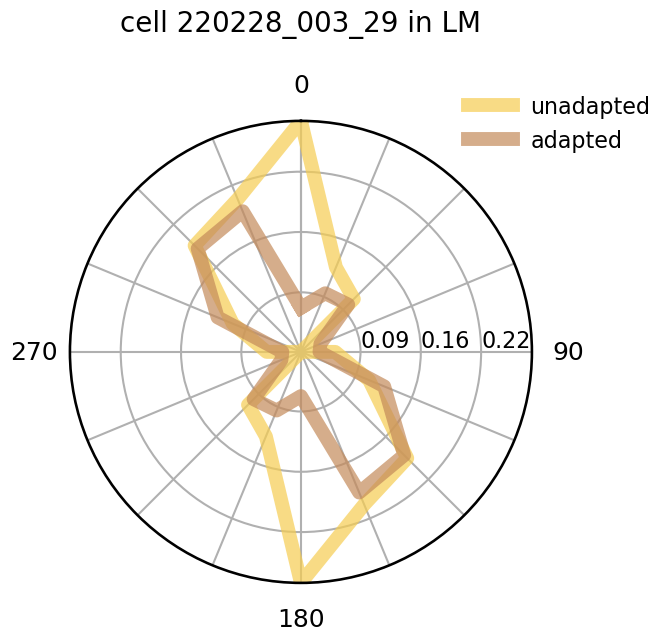

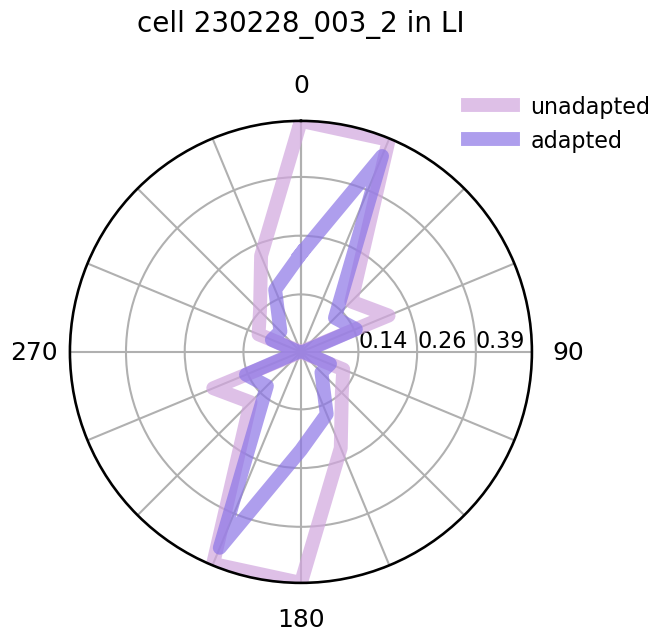

In [324]:
# color_list = '85a7eb-ced3f2-f6cd51-e4cab4-d1a6de-fa9ce0'
color_list = '85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-8c75e6' # from https://coolors.co/85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-c715f4
color_list = color_list.split('-') # V1 (unadapted, adapted) - LM (unadapted, adapted) - LI (unadapted, adapted)
color_list = ['#' + i for i in color_list]

for icell in ['200803_002_55', '220228_003_29', '230228_003_2']:
# for icell in tqdm(df_tuning[(df_tuning.area == 'LM') 
#                             # & (df_tuning.tuning_bias >= 45)
#                             ].cell_id.unique()[10:20]):

    icell_area = df_tuning[df_tuning.cell_id == icell].area.values[0]
    if icell_area == 'V1':
        color_unadapted = color_list[0]
        color_adapted = color_list[1]
    elif icell_area == 'LM':
        color_unadapted = color_list[2]
        color_adapted = color_list[3]
    elif icell_area == 'LI':
        color_unadapted = color_list[4]
        color_adapted = color_list[5]

    # gOSI_noad = df_tuning[df_tuning.cell_id == icell].gOSI_noad.values[0]
    # gOSI_250 = df_tuning[df_tuning.cell_id == icell].gOSI_250.values[0]

    ## convert tuning_noad, a string of list, to an actual list
    tuning_noad = df_tuning[df_tuning.cell_id == icell].tuning_noad.values[0]
    if type(tuning_noad) == str:
        tuning_noad = tuning_noad.replace('[', '').replace(']', '').replace('  ', ' ').replace('\n', '').strip().split(' ')
        tuning_noad = [float(i) for i in tuning_noad]
    tuning_noad = np.append(tuning_noad, tuning_noad) # repeat 8 values twice to make 16 values for polar plot
    tuning_noad = np.append(tuning_noad, tuning_noad[0]) # repeat first value at the end to close the circle

    # # ori_pref_noad = df_tuning[df_tuning.cell_id == icell].ori_pref_noad.values[0]
    # ori_pref_noad = df_tuning[df_tuning.cell_id == icell].pref_ori_noad.values[0]
    # # print('ori_pref_noad deg: ', np.round(ori_pref_noad, 2))
    # ori_pref_noad = ori_pref_noad * np.pi / 180 # degree to radian

    tuning_250 = df_tuning[df_tuning.cell_id == icell].tuning_250.values[0]
    if type(tuning_250) == str:
        tuning_250 = tuning_250.replace('[', '').replace(']', '').replace('  ', ' ').replace('\n', '').strip().split(' ')
        tuning_250 = [float(i) for i in tuning_250]
    tuning_250 = np.append(tuning_250, tuning_250)
    tuning_250 = np.append(tuning_250, tuning_250[0])
    # # ori_pref_ad_250 = df_tuning[df_tuning.cell_id == icell].ori_pref_ad_250.values[0]
    # ori_pref_ad_250 = df_tuning[df_tuning.cell_id == icell].pref_ori_ad_250.values[0]
    # # print('ori_pref_ad_250 deg: ', np.round(ori_pref_ad_250, 2))
    # ori_pref_ad_250 = ori_pref_ad_250 * np.pi / 180

    # tuning_bias = df_tuning[df_tuning.cell_id == icell].tuning_bias.values[0]
    # print('no adapter: ', np.round(tuning_noad, 2))
    # print('250 ms: ', np.round(tuning_250, 2))
    # print('tuning_bias: ', np.round(tuning_bias, 2))


    fig, ax = plt.subplots(1, 1, figsize=(6, 6), subplot_kw=dict(projection='polar'))
    ax.plot(np.linspace(0, 2*np.pi, 17), tuning_noad, 
            alpha=.7, linewidth=10, label='unadapted', color=color_unadapted)
    ax.plot(np.linspace(0, 2*np.pi, 17), tuning_250, 
            alpha=.7, linewidth=10, label='adapted', color=color_adapted)

    # plot adapter ori as a line
    min_val = np.min([np.min(tuning_noad), np.min(tuning_250)])
    max_val = np.max([np.max(tuning_noad), np.max(tuning_250)])
    # ax.plot([0, np.pi], [max_val, max_val], color='gray', linewidth=5, alpha=.5, label='adapter ori')

    # ## plot 90 deg as a line
    # ax.plot([np.pi/2, np.pi/2], [min_val, max_val], color='cyan', linewidth=5, alpha=.5, linestyle='-')
    # ax.plot([np.pi*3/2, np.pi*3/2], [min_val, max_val], color='cyan', linewidth=5, alpha=.5, linestyle='-')

    # ## plot pref ori (noad) as a line
    # ax.plot([ori_pref_noad, ori_pref_noad], [min_val, max_val], color='blue', linewidth=5, alpha=.5, label='pref ori no adapter')
    # ori_pref_noad_opp = ori_pref_noad + np.pi # find opposite orientation of pref ori
    # if ori_pref_noad_opp > 2*np.pi:
    #     ori_pref_noad_opp = ori_pref_noad_opp - 2*np.pi
    # ax.plot([ori_pref_noad_opp, ori_pref_noad_opp], [min_val, max_val], color='blue', linewidth=5, alpha=.5, linestyle='-')

    # ## plot pref ori (ad 250) as a line
    # ax.plot([ori_pref_ad_250, ori_pref_ad_250], [min_val, max_val], color='orange', linewidth=5, alpha=.5, label='pref ori isi=250')
    # ori_pref_ad_250_opp = ori_pref_ad_250 + np.pi
    # if ori_pref_ad_250_opp > 2*np.pi:
    #     ori_pref_ad_250_opp = ori_pref_ad_250_opp - 2*np.pi
    # ax.plot([ori_pref_ad_250_opp, ori_pref_ad_250_opp], [min_val, max_val], color='orange', linewidth=5, alpha=.5, linestyle='-')

    # ## add text at top left
    # bias_color = 'blue'
    # minus_flag = 'pos'
    # if tuning_bias < 0: # attractive bias
    #     bias_color = 'red'
    #     minus_flag = 'neg'
    # plt.text(0.05, 0.9, f'tuning_bias: {np.round(tuning_bias, 2)}', transform=plt.gcf().transFigure, color=bias_color, fontsize=16) # in cartesian coordinates

    # gOSI_color = 'green'
    # if gOSI_noad < 0.5 or gOSI_250 < 0.5:
    #     gOSI_color = 'orange'
    # if gOSI_noad < 0.5 and gOSI_250 < 0.5:
    #     gOSI_color = 'red'
    # plt.text(0.05, 0.85, f'gOSI_noad: {np.round(gOSI_noad, 2)}', transform=plt.gcf().transFigure, color=gOSI_color, fontsize=16) # in cartesian coordinates
    # plt.text(0.05, 0.8, f'gOSI_250: {np.round(gOSI_250, 2)}', transform=plt.gcf().transFigure, color=gOSI_color, fontsize=16) # in cartesian coordinates

    rticks = np.arange(0, max_val, step=0.05)
    ax.set_rticks(rticks)  # fewer radial ticks
    ax.set_rlabel_position(90)  # Move radial labels away from plotted line
    ax.set_xticks(np.linspace(0, 2*np.pi, 17))
    ax.tick_params(pad=10) # set tick label distance from axis
    ax.set_xticklabels(np.arange(0, 360+22.5, 22.5))
    xticklabels = [label.get_text() for label in ax.get_xticklabels()]
    
    for i, label in enumerate(xticklabels): # make only every 4th xticklabel visible
        if i % 4 != 0:
            xticklabels[i] = ''
        else:
            xticklabels[i] = int(float(label))
    xticklabels[-1] = '' # set final xticklabel invisible    
    ax.set_xticklabels(xticklabels, fontsize=18)

    yticklabels = np.linspace(my_floor(min_val, 2), my_ceil(max_val, 2), 5)
    ax.set_yticks(yticklabels)
    yticklabels = [np.round(float(label), 2) for label in yticklabels] # round yticklabels to 2 decimal places
    ax.set_yticklabels(yticklabels, fontsize=16)
    ax.set_ylim(min_val, max_val)

    area = df_tuning[df_tuning.cell_id == icell].area.values[0]
    ax.set_title(f'cell {icell} in {area}', pad=30, fontsize=20)
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.legend(bbox_to_anchor=(1.3, 1.1), frameon=False, fontsize=16); # set legend position out of the way

    # break

    # save figure
    dir_result = r'C:\Users\ll357\Documents\inter\results\tuning bias\polar plot - tuning bias single cell/'.replace('\\', '/')
    fig.savefig(os.path.join(dir_result, f'{icell_area}_{icell}_tuning_curve_fontsize.svg'), bbox_inches='tight')
    # plt.close(fig)
    # clear_output(wait=True)

# gOSI across areas
calculate global orientation selectivity index (gOSI)  
formula taken from [Causal importance of orientation selectivity for generalization in image recognition](https://openreview.net/pdf?id=Bkx_Dj09tQ)

In [335]:
# for icell in tqdm(df_tuning.cell_id.unique()): # NOTE: df_tuning cells already passed R1-ori0 filter. takes 5 min
#     df_cell = df_tuning[df_tuning.cell_id == icell]

#     # tuning_noad = df_cell.tuning_noad.values[0] - min(df_cell.tuning_noad.values[0]) # ensure all values are non negative
#     # tuning_250 = df_cell.tuning_250.values[0] - min(df_cell.tuning_250.values[0])

#     ## convert tuning_isi from a string of list to an actual list
#     tuning_noad = df_tuning[df_tuning.cell_id == icell].tuning_noad.values[0]
#     if type(tuning_noad) == str:
#         tuning_noad = tuning_noad.replace('[', '').replace(']', '').replace('  ', ' ').replace('\n', '').strip().split(' ')
#         tuning_noad = [float(i) for i in tuning_noad if len(i) > 0] # remove empty string
#     tuning_noad = np.array(tuning_noad) - min(tuning_noad) # ensure all values are non negative

#     tuning_250 = df_tuning[df_tuning.cell_id == icell].tuning_250.values[0]
#     if type(tuning_250) == str:
#         tuning_250 = tuning_250.replace('[', '').replace(']', '').replace('  ', ' ').replace('\n', '').strip().split(' ')
#         tuning_250 = [float(i) for i in tuning_250 if len(i) > 0]
#     tuning_250 = np.array(tuning_250) - min(tuning_250)


#     theta_arr = np.linspace(0, 180-22.5, 8) # according to formula: unit deg, not rad
#     sin_arr = np.sin(2 * theta_arr)
#     cos_arr = np.cos(2 * theta_arr)

#     gOSI_noad = np.sqrt((np.sum(tuning_noad * sin_arr))**2 + (np.sum(tuning_noad * cos_arr))**2) / np.sum(tuning_noad)
#     gOSI_250 = np.sqrt((np.sum(tuning_250 * sin_arr))**2 + (np.sum(tuning_250 * cos_arr))**2) / np.sum(tuning_250)

#     df_tuning.loc[df_tuning.cell_id == icell, 'gOSI_noad'] = gOSI_noad
#     df_tuning.loc[df_tuning.cell_id == icell, 'gOSI_250'] = gOSI_250

# df_tuning = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False)

,area,gOSI_noad,gOSI_250
cell_id,,,
201209_002_88,V1,0.876308,0.682645
200728_003_33,V1,0.866154,0.729479
201015_004_15,V1,0.849340,0.496406
201015_004_12,V1,0.846736,0.789616
220228_002_16,LM,0.845744,0.809035
...,...,...,...
200728_003_72,V1,0.017878,0.317335
200804_003_68,LM,0.015051,0.136653
230302_003_136,LM,0.014923,0.443175


In [444]:
df_gOSI = df_tuning.groupby('cell_id', sort=False)[['area', 'gOSI_noad', 'gOSI_250']].first().reset_index()
color_list = '85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-8c75e6' # originally https://coolors.co/85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-c715f4, changed last color
color_list = color_list.split('-') # V1 (unadapted, adapted) - LM (unadapted, adapted) - LI (unadapted, adapted)
color_list = ['#' + i for i in color_list]
color_list_noad = color_list[::2]
color_list_250 = color_list[1::2]

isi_now = 6000
# isi_now = 250

if isi_now == 6000:
    gOSI_V1 = df_gOSI[df_gOSI.area == 'V1'].gOSI_noad.values
    gOSI_LM = df_gOSI[df_gOSI.area == 'LM'].gOSI_noad.values
    gOSI_LI = df_gOSI[df_gOSI.area == 'LI'].gOSI_noad.values
    palette = color_list_noad
elif isi_now == 250:
    gOSI_V1 = df_gOSI[df_gOSI.area == 'V1'].gOSI_250.values
    gOSI_LM = df_gOSI[df_gOSI.area == 'LM'].gOSI_250.values
    gOSI_LI = df_gOSI[df_gOSI.area == 'LI'].gOSI_250.values
    palette = color_list_250

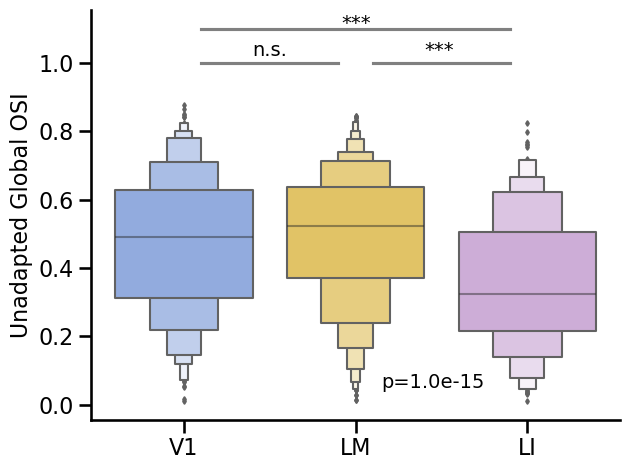

In [455]:
# ax = sns.violinplot(data=[gOSI_V1, gOSI_LM, gOSI_LI], 
#                 palette=palette, 
#                 notch=True
#                 )

ax = sns.boxenplot(data=[gOSI_V1, gOSI_LM, gOSI_LI], 
                palette=palette, 
                linewidth=1.5, 
                flier_kws=dict(s=5), #box_kws=dict(alpha=.7)
                )

## set alpha for violin plot
if isi_now == 250:
    for violin in ax.collections[::2]:
        violin.set_alpha(0.6)
    plt.setp(ax.lines, alpha=.6)

## add pvlaue for kruskal wallis test (non-parametric ANOVA)
_, p_kruskal = stats.kruskal(gOSI_V1, gOSI_LM, gOSI_LI)
plt.text(1.15, 0.05, 'p={:.1e}'.format(p_kruskal), fontsize=14)

## add significance stars for posthoc mann whitney u test (Wilcoxon rank-sum test)
_, p_mannwhit_V1LM = stats.mannwhitneyu(gOSI_V1, gOSI_LM)
_, p_mannwhit_LMLI = stats.mannwhitneyu(gOSI_LM, gOSI_LI)
_, p_mannwhit_V1LI = stats.mannwhitneyu(gOSI_V1, gOSI_LI)
p_mannwhit = [p_mannwhit_V1LM, p_mannwhit_LMLI, p_mannwhit_V1LI]
sig_star_str = []
for i, pval in enumerate(p_mannwhit):
    if pval < 0.001:
        sig_star_str.append('***')
    elif pval < 0.01:
        sig_star_str.append('**')
    elif pval < 0.05:
        sig_star_str.append('*')
    else:
        sig_star_str.append('n.s.')

## first, draw horizontal lines to connect pairs of groups
sig_bar_y = 1
sig_bar_shorten = 0.1
plt.plot([0+sig_bar_shorten, 1-sig_bar_shorten], [sig_bar_y, sig_bar_y], 'gray')
# sig_bar_y += 0.2
plt.plot([1+sig_bar_shorten, 2-sig_bar_shorten], [sig_bar_y, sig_bar_y], 'gray')
sig_bar_y += 0.1
plt.plot([0+sig_bar_shorten, 2-sig_bar_shorten], [sig_bar_y, sig_bar_y], 'gray')

## then, draw significance stars
sig_star_y_base = 1.02
sig_star_y = [sig_star_y_base, sig_star_y_base, sig_star_y_base+0.08]
sig_star_x = [0.4, 1.4, 0.92] # V1-LM, LM-LI, V1-LI
for i, sig_star in enumerate(sig_star_str):
    plt.text(sig_star_x[i], sig_star_y[i], sig_star, fontsize=14)

plt.xticks([0, 1, 2], ['V1', 'LM', 'LI'], fontsize=16);
if isi_now == 6000:
    isi_str = 'Unadapted'
elif isi_now == 250:
    isi_str = 'Adapted'
plt.ylabel(f'{isi_str} Global OSI', fontsize=16);
sns.despine();
plt.tight_layout();
# plt.savefig(os.path.join(dir_fig, f'gOSI_across_area_{isi_now}ms_boxenplot.svg'))

In [446]:
## post hoc
stats.mannwhitneyu(gOSI_V1, gOSI_LM), stats.mannwhitneyu(gOSI_V1, gOSI_LI), stats.mannwhitneyu(gOSI_LM, gOSI_LI)

(MannwhitneyuResult(statistic=162868.0, pvalue=0.07872269381588512),
 MannwhitneyuResult(statistic=51645.0, pvalue=6.28936221623988e-10),
 MannwhitneyuResult(statistic=119120.0, pvalue=6.629255990034144e-17))

In [459]:
## dunn test (posthoc test for kruskal wallis): https://scikit-posthocs.readthedocs.io/en/latest/generated/scikit_posthocs.posthoc_dunn.html
sp.posthoc_dunn([gOSI_V1, gOSI_LM], p_adjust='bonferroni'), sp.posthoc_dunn([gOSI_V1, gOSI_LI], p_adjust='bonferroni'), sp.posthoc_dunn([gOSI_LM, gOSI_LI], p_adjust='bonferroni')

(          1         2
 1  1.000000  0.078709
 2  0.078709  1.000000,
               1             2
 1  1.000000e+00  6.279305e-10
 2  6.279305e-10  1.000000e+00,
               1             2
 1  1.000000e+00  6.622108e-17
 2  6.622108e-17  1.000000e+00)

## gOSI across isi

In [461]:
gOSI_V1_6000 = df_gOSI[df_gOSI.area == 'V1'].gOSI_noad.values
gOSI_LM_6000 = df_gOSI[df_gOSI.area == 'LM'].gOSI_noad.values
gOSI_LI_6000 = df_gOSI[df_gOSI.area == 'LI'].gOSI_noad.values

gOSI_V1_250 = df_gOSI[df_gOSI.area == 'V1'].gOSI_250.values
gOSI_LM_250 = df_gOSI[df_gOSI.area == 'LM'].gOSI_250.values
gOSI_LI_250 = df_gOSI[df_gOSI.area == 'LI'].gOSI_250.values

In [466]:
## paired t test
(stats.ttest_rel(gOSI_V1_6000, gOSI_V1_250, alternative='greater'), # expect gOSI to be higher when isi=6000
 stats.ttest_rel(gOSI_LM_6000, gOSI_LM_250, alternative='greater'), 
 stats.ttest_rel(gOSI_LI_6000, gOSI_LI_250, alternative='greater'))

(TtestResult(statistic=3.6719803758216933, pvalue=0.00013680845933802227, df=397),
 TtestResult(statistic=8.755834024618768, pvalue=5.201445192211869e-18, df=871),
 TtestResult(statistic=2.143923993739637, pvalue=0.01663226187225555, df=197))